# Project: Time Series - Forecasting the number of Air Passengers
**Marks: 30**

Dear Learner,

Welcome to project on Time Series. We will use the Air Passengers for the exercise.
Do read the problem statement and the guidelines around the same.

----
## Context: 
-------

This dataset provides monthly totals of a US airline passengers (in thousands) from the period of 1949 to 1960. This dataset is taken from an inbuilt dataset of R called AirPassengers.

---------
## Objective:
------------
You are a data scientist for this airline and they want to forecast the monthly number of passengers for the next 24 months (i.e for the period of 1961-1962) to balance their manpower hiring and decision on the additional/alteration in the existing and new routes. This forecast will also help the airline to set their dynamic pricing according to the need.

--------
## Attributes Information:
------------
- 'Year-Month' ----> Month and Year starting from 01-01-1949
- '# Passengers' ----> Total number of passengers for a particular month

---------------------------
## Guidelines
-----------------------------------------
- The exercise consists of semi written code blocks. You need to fill the blocks (_______) as per the instructions to achieve the required results.
- To be able to complete the assessment in the expected time, do not change the variable names. The codes might throw errors when the names are changed. 
- The marks of each requirement is mentioned in the question.
- You can raise your issues on the discussion forum on Olympus.
- You can use Jupyter Notebook/ Google Colab(recommended) for this assessment.
--------------------------------------------
Wishing you all the best!

### Import libraries

In [1]:
# Install this to upgrade the statsmodels package. It will be required to use AR, MA, & ARMA models
!pip install statsmodels --upgrade

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.1
    Uninstalling statsmodels-0.12.1:
      Successfully uninstalled statsmodels-0.12.1


In [34]:
# To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

#Importing library for date manipulation
from datetime import datetime

### Reading the dataset

In [36]:
# Mount your drive if you are using Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
#Reading the dataset
df = pd.read_excel('AirPassenger.xlsx')
df.head()

,Year-Month,# Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [38]:
#Check the shape of the dataset
df.shape

(144, 2)

In [39]:
#Setting the date as an index to make the dataset with only one column

df['Year-Month'] = pd.to_datetime(df['Year-Month'], infer_datetime_format=True)
df = df.set_index(['Year-Month'])
df.head()

,# Passengers
Year-Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


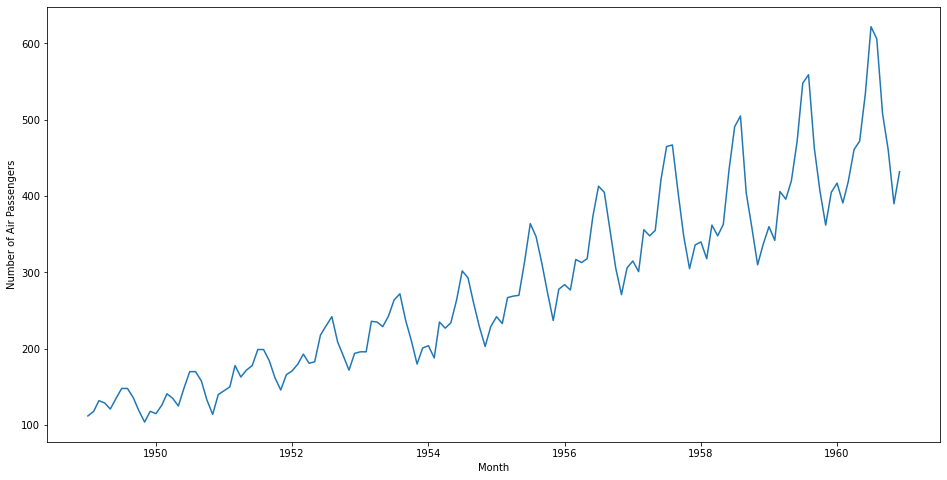

In [40]:
# Visualizing the time series dataset
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")
plt.plot(df)

**Observations**
- We can see that the series has a upward trend with some seasonality
- Before modelling with AR, MA or ARMA, we need to check whether the series is stationary or not
- Let us first check the rolling mean and standard deviation of the series if we can visualize any trend or seaonality

### Calculating and Visualizing the rolling mean & standard deviation of the series (for 12 observations) to check the stationarity of the time series (2 marks)

In [41]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df.rolling(window=12).mean()    #calculate the mean here
rolstd=df.rolling(window=12).std()     #calculate the standard deviation here
print(rolmean.head(15))
print('*****************************')
print('*****************************')
print(rolstd.head(15))

            # Passengers
Year-Month              
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01    126.666667
1950-01-01    126.916667
1950-02-01    127.583333
1950-03-01    128.333333
*****************************
*****************************
            # Passengers
Year-Month              
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01           NaN
1949-08-01           NaN
1949-09-01           NaN
1949-10-01           NaN
1949-11-01           NaN
1949-12-01     13.720147
1950-01-01     13.453342
1950-02-01     13.166475
1950-03-01     13.686977


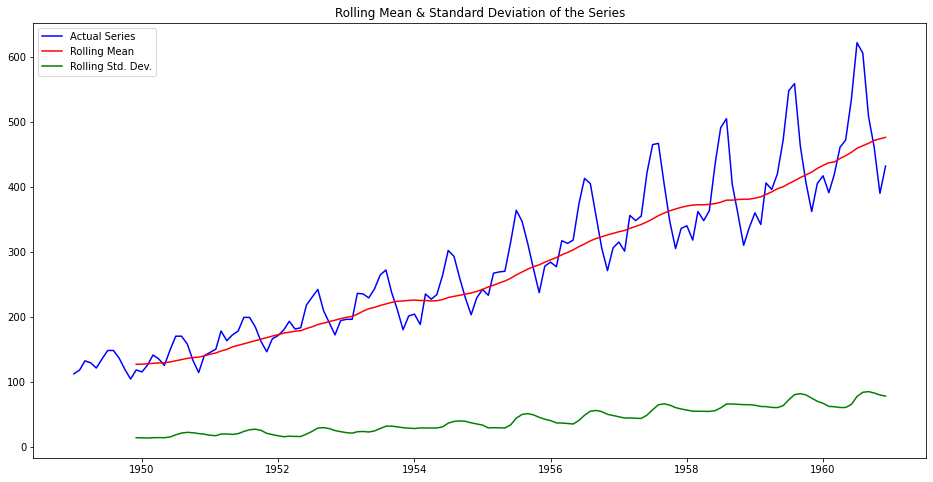

In [42]:
#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df, color='blue', label='Actual Series')     #filling in the df dataframe name
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean')    #filling in the rolmean dataframe name 
rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')   #filling in Std. dataframe name
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**

### Testing the stationarity of the series using Augmented Dickey-Fuller Test

The hypotheses for ADF test are defined as 
-        Null hypothesis         - Time Series is non-stationary
-        Alternative hypothesis  - Time Series is stationary

In [43]:
#Define a function to use adfuller test
def adfuller(df):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df['# Passengers'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df)

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Observations     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


**Observations**
1. From the above test, we see that the p-value = 0.991880 i.e. > 0.1 (For 90% confidence intervals) therefore, we fail to reject the null hypothesis.
2. Hence, we can confirm that the series is non-stationary

### Making the series stationary (5 marks)

We can use the following methods to make a non-stationary series to stationary.
1. Log transformation
2. Differencing
3. By shifting the series (lagged series)

Let's first use the log transfromation over this series to remove exponential variance and again check the stationarity of the series

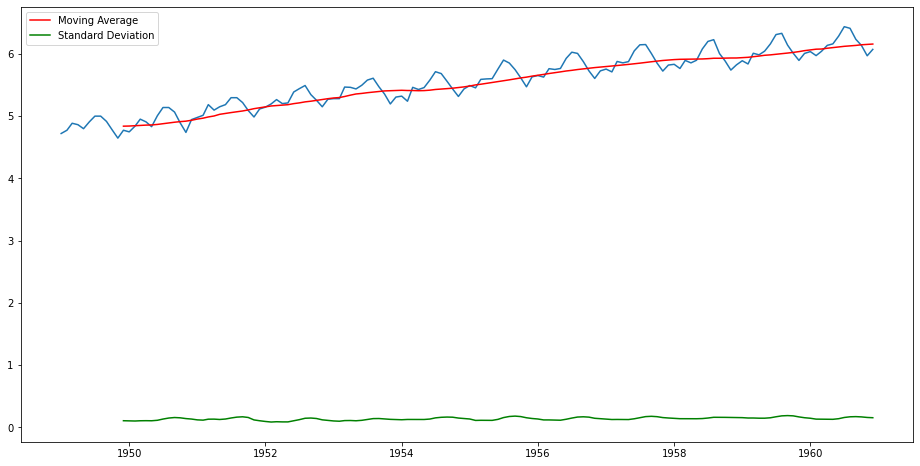

In [44]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df)
MAvg = df_log.rolling(window=12).mean()   #calculate the mean
MStd = df_log.rolling(window=12).std()   #calculate the standard deviation
plt.plot(df_log)                            #plot the dataframe with log transformation
plt.plot(MAvg, color='r', label = 'Moving Average')   #plot the moving average of the dataframe with log transformation
plt.plot(MStd, color='g', label = 'Standard Deviation')   #plot the standard deviation of the dataframe with log transformation
plt.legend()
plt.show()

**Observations:**

Let's use differencing method over the series to remove temporal dependence (trend) and again check the stationarity of the series

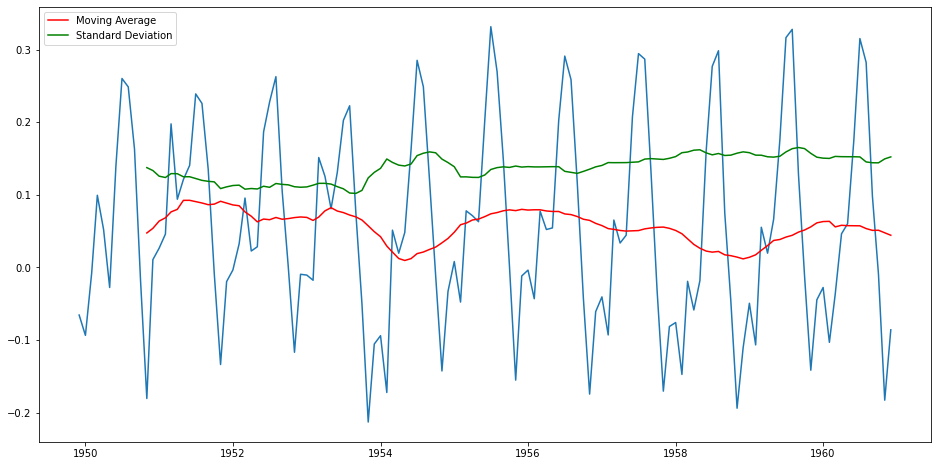

In [45]:
# Visualize the rolling mean and standard deviation after using log transform and differencing 
plt.figure(figsize=(16,8))
df_log_diff = df_log - MAvg
MAvg_diff = df_log_diff.rolling(window=12).mean()    #calculate the mean
MStd_diff = df_log_diff.rolling(window=12).std()    #calculate the standard deviation
plt.plot(df_log_diff)                                #plot the dataframe with differencing
plt.plot(MAvg_diff, color='r', label = 'Moving Average')  #plot the moving average of the dataframe with differencing
plt.plot(MStd_diff, color='g', label = 'Standard Deviation') #plot the standard deviation of the dataframe with differencing
plt.legend()
plt.show()

#Dropping the null values that we get after applying diffrencing method
df_log_diff = df_log_diff.dropna()

**Observations:**

In [46]:
#Using the adfuller function for df_log_diff
adfuller(df_log_diff)

Dickey-Fuller Test: 
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:** We reject this null hypothesis because the P-value (0.022235) above is less then 0.05.[P-value < 0.05].

Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series) and then check the rolling mean and standard deviation

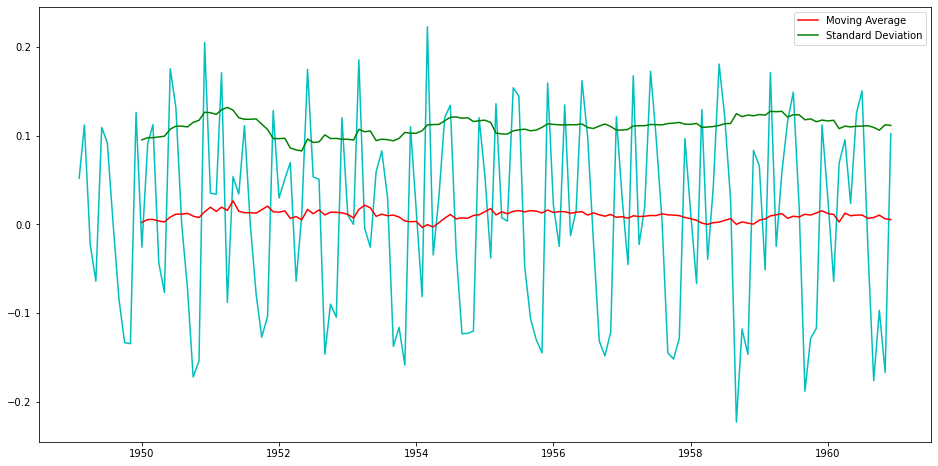

In [47]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()   #calculate the mean
MStd_shift = df_shift.rolling(window=12).std()   #calculate the standard deviation
plt.plot(df_shift, color='c')                       #plot the dataframe with lag
plt.plot(MAvg_shift, color='red', label = 'Moving Average')    #plot the moving average of the dataframe with lag
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')    #plot the standard deviation of the dataframe with lag
plt.legend()
plt.show()

#Dropping the null values that we get after applying diffrencing method
df_shift = df_shift.dropna()

**Observations:**

In [48]:
#Using the adfuller function for df_shift
adfuller(df_shift)

Dickey-Fuller Test: 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Observations     128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


**Observations:** P-Value is above 0.05 (P-value>0.05 or over 90% of confidence intervals) therefore we fail to reject the null hypothesis. This series is non-stationary. 

**Note:** *We will use the lag 1 series (df_shift) for AR, MA & ARMA models.*

### Decomposing the time series components into Trend, Seasonality and Residual (3 marks)

Let us decompose the time series to separate the components of the time series

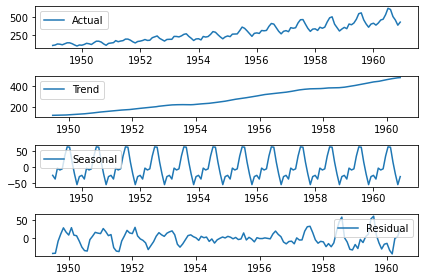

In [49]:
#Importing the seasonal_decompose to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df)      #Use the actual series to decompose

#Below are the 3 decomposition for the time series in Trend, seasonality and residual.
trend = decomp.trend        
seasonal = decomp.seasonal
residual = decomp.resid

# plots
plt.subplot(411)
plt.plot(df, label='Actual')   # plot for the actual Series
plt.legend()
plt.subplot(412)
plt.plot(trend, label='Trend')        # plot for the Trend
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')   # plot for the Seasonal
plt.legend()
plt.subplot(414)
plt.plot(residual, label='Residual')   # plot for the residual
plt.legend()
plt.tight_layout()

**Observations:** Seasonality exist in the data shown above. Seasonality between 1958 and 1960 is of the same magnitude and period as in Residual between the same years(1958  > 1960). This show that seasonality became stronger over the period between 1958 and 1960. 

### Plotting the auto-correlation function and partial auto-correlation function to get p and q value for AR, MA and ARMA models

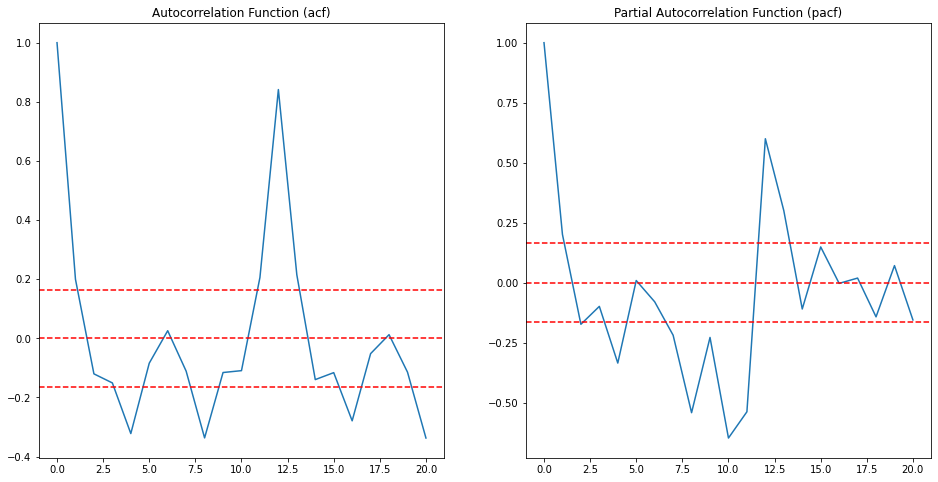

In [50]:
#Importing acf and pacf functions
from statsmodels.tsa.stattools import acf, pacf
#Using 20 lags in the series
lag_acf = acf(df_shift, nlags=20)
lag_pacf = pacf(df_shift, nlags=20, method='ols')

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.title('Autocorrelation Function (acf)')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='red')
plt.title('Partial Autocorrelation Function (pacf)')
plt.show()

**Observations**
- We can see that in both plots, the blue line is entering into the confidence interval (dotted red) at 2, therefore we will be using the values of p, q values as 2

### AR Model (3 marks)

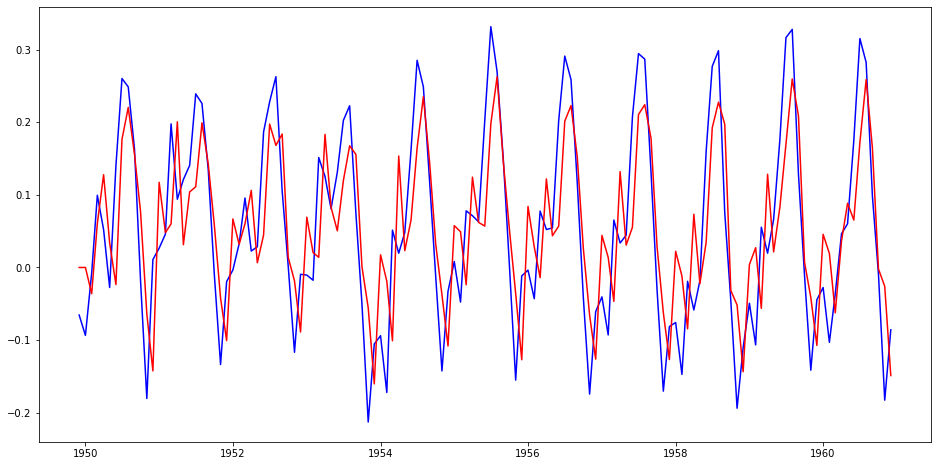

In [60]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

#Comparing the actual & predicted series by AR model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model_AR = AutoReg(df_log_diff, lags= 2) #Using number of lags as 2
results_AR = model_AR.fit()
plt.plot(df_log_diff, label = 'Actual', color ='b')   #Visualizing the actual series used for modelling
predict = results_AR.predict(start=0,end=len(df_log_diff)-1)
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, label = 'AR Predicted', color='red')
plt.title('AR Model - RSS: %.4f'% format(sum(predict-df_log_diff)**2))   #calculate the residual sum of squares
plt.show()

**Observations**
- We can see that by using AR model, we get RSS = 2.5%
- Let us use MA and ARMA models and see if we can reduce the RSS

### MA Model (3 marks)

We will be using ARMA model with p=0 so that it will work as MA Model

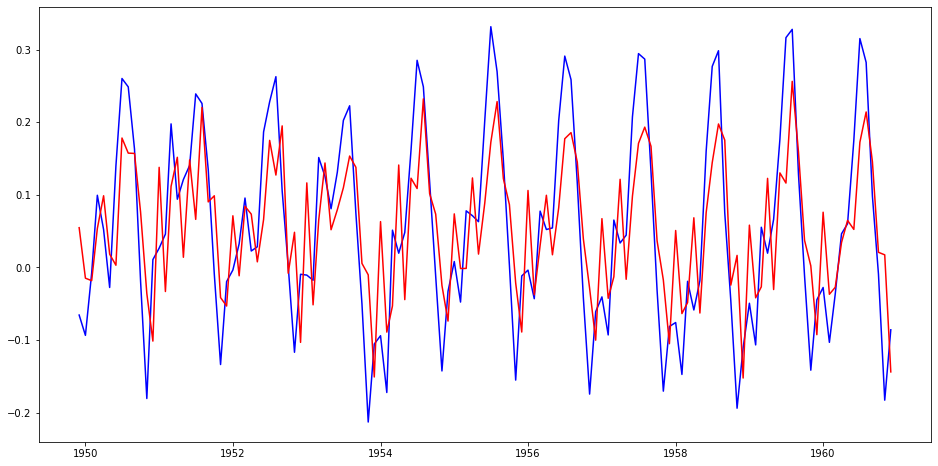

In [62]:
#Importing ARMA
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by MA model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model_MA = ARMA(df_log_diff, order=(0,2)) #Using p=0 and q=2
results_MA = model_MA.fit()
plt.plot(df_log_diff, label='Actual', color='b')             #Visualzing the actual series used for modelling
plt.plot(results_MA.fittedvalues, label='Results_MA', color='red')
#plt.title('MA Model - RSS: %.4f'% format(sum(results_MA-df_log_diff)**2))    #calculate the residual sum of squares
plt.show()

**Observations**
- We can see that by using MA model, we get RSS = 2 i.e. 0.5 less than AR model
- Let us use ARMA model and see if we can reduce the RSS

### ARMA Model (5 marks)

We will using p=2 and q=2 as inferred from acf and pacf

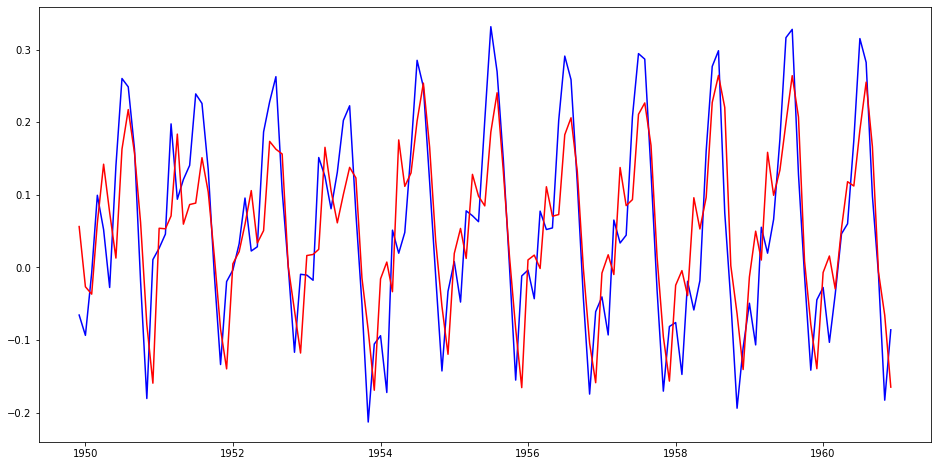

In [64]:
from statsmodels.tsa.arima_model import ARMA

#Comparing the actual & predicted series by AR model and calculating the Residual Sum of Squares
plt.figure(figsize=(16,8))
model = ARMA(df_log_diff, order=(2,2)) #Using p=2, q=2
results = model.fit()
plt.plot(df_log_diff, label='Actual', color='b')            #Visualizing the actual series used for modelling
plt.plot(results.fittedvalues, label='Predicted-Results', color='red')
#plt.title('ARMA Model - RSS: %.4f'% format(sum(results-df_log_diff)**2))   #calculate the residual sum of squares
plt.show()  

In [65]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:           # Passengers   No. Observations:                  133
Model:                     ARMA(2, 2)   Log Likelihood                 144.780
Method:                       css-mle   S.D. of innovations              0.081
Date:                Sat, 06 Feb 2021   AIC                           -277.560
Time:                        21:26:21   BIC                           -260.217
Sample:                    12-01-1949   HQIC                          -270.512
                         - 12-01-1960                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0563      0.005     10.621      0.000       0.046       0.067
ar.L1.# Passengers     1.4884      0.078     19.033      0.000       1.335       1.642
ar.L2.# Passengers  

In [66]:
#Printing the fitted values
predictions=pd.Series(results.fittedvalues)
predictions

Year-Month
1949-12-01    0.056344
1950-01-01   -0.026575
1950-02-01   -0.036694
1950-03-01    0.061120
1950-04-01    0.142173
                ...   
1960-08-01    0.255169
1960-09-01    0.166234
1960-10-01   -0.006325
1960-11-01   -0.065750
1960-12-01   -0.164731
Length: 133, dtype: float64

**Observations:**
- We can see that by using ARMA model, we get RSS = ________ i.e lesser than both AR and MA models
- Since ARMA model gives us the best RSS, we will forecast the values using ARMA

### Inverse Transformation (5 marks)

Since we now have the fitted values by ARMA model, we will use the inverse transformation to get the original values.

In [68]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum()    #Use the predicted values series
predictions_cumsum

Year-Month
1949-12-01    0.056344
1950-01-01    0.029768
1950-02-01   -0.006926
1950-03-01    0.054195
1950-04-01    0.196367
                ...   
1960-08-01    7.468330
1960-09-01    7.634564
1960-10-01    7.628238
1960-11-01    7.562488
1960-12-01    7.397757
Length: 133, dtype: float64

In [69]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['# Passengers'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)   #Use the series with cumulative sum
predictions_log

Year-Month
1949-01-01     4.718499
1949-02-01     4.718499
1949-03-01     4.718499
1949-04-01     4.718499
1949-05-01     4.718499
                ...    
1960-08-01    12.186829
1960-09-01    12.353063
1960-10-01    12.346737
1960-11-01    12.280987
1960-12-01    12.116256
Length: 144, dtype: float64

In [70]:
#Third step - applying exponential transformation
predictions_ARMA = np.exp(predictions_log)       #Use the series with log values
predictions_ARMA

Year-Month
1949-01-01       112.000000
1949-02-01       112.000000
1949-03-01       112.000000
1949-04-01       112.000000
1949-05-01       112.000000
                  ...      
1960-08-01    196187.977317
1960-09-01    231668.452784
1960-10-01    230207.722415
1960-11-01    215558.380831
1960-12-01    182819.685493
Length: 144, dtype: float64

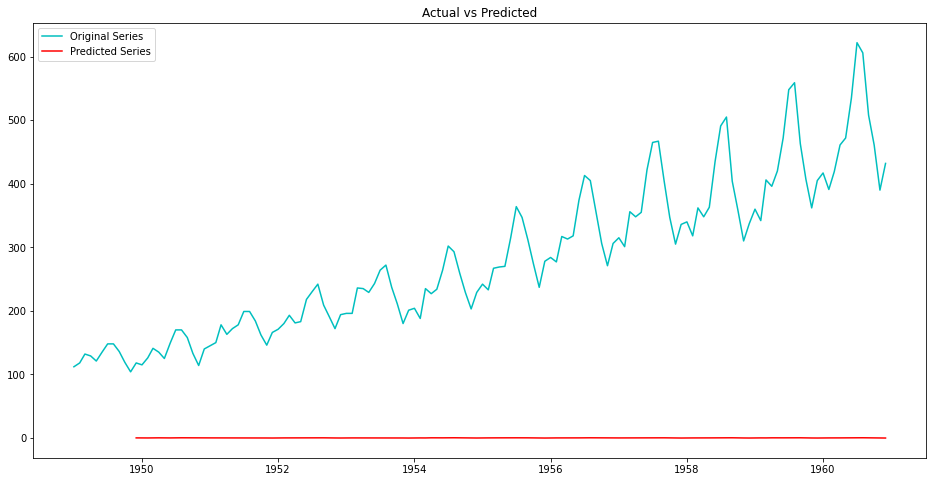

In [71]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions, color = 'r', label = 'Predicted Series')       #Use the series with predicted values
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations**
- We can see that the predicted series is very similar to that of original series
- Let us forecast the number of passengers for next 24 months

### Forecasting the number of passengers for next 24 months (4 marks)

In order to forecast the values for next 24 months, we need to follow the below steps-
1. Forecast the fitted values for next 24 months
2. Make a combined list containing the previous fitted values by ARMA model (1949-1960 and these 24 months (1961-1962) forecasted values
3. Convert that combined list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 01-01-1949 to 12-01-1962 as the index and the respective predicted cumulative sum values
5. Add the log values of the original series in the same dataframe from 1949-1960 and 1961-1962 as NaN (since we don't know the original number of passengers for this period)
6. Applying the inverse tranformation and get the forecasted number of passengers

In [72]:
#Forecasting the values for next 24 months
predictions_ARMA = results.forecast(steps=24) # here steps represent the number of months
predictions_ARMA[0]

array([-0.02119984,  0.04297905,  0.09548705,  0.12478128,  0.12840844,
        0.1115048 ,  0.08358321,  0.0548926 ,  0.03344564,  0.0233659 ,
        0.02469089,  0.03433704,  0.04768606,  0.06021149,  0.06869195,
        0.07177872,  0.06991681,  0.06479542,  0.05859003,  0.0532527 ,
        0.05003268,  0.04930332,  0.05066919,  0.05325749])

In [73]:
#Converting the fitted values by ARMA into a list
predictions_list = predictions.tolist()
#Converting the forecasted values by ARMA into a list
predictions_ARMA_list = predictions_ARMA[0].tolist()
#combining the both lists
predictions_list.extend(predictions_ARMA_list)
predictions_list

[0.05634358098523229,
 -0.02657543893094033,
 -0.0366937571572189,
 0.061120194353469215,
 0.14217271408681428,
 0.07564221039664602,
 0.012957813081446334,
 0.16291925692686876,
 0.21736224380872193,
 0.15754669211440808,
 0.06232344228654366,
 -0.0785367831372791,
 -0.15928980200092302,
 0.05398831302982379,
 0.05326516994864629,
 0.07095240998098029,
 0.18361681356911713,
 0.05964470912514544,
 0.08665671018609748,
 0.08863945314396082,
 0.15114787782637873,
 0.10386768376517361,
 0.015870967141705272,
 -0.08505521712614361,
 -0.13959186437907053,
 0.00507270805865459,
 0.021789307245909273,
 0.0594129796647797,
 0.10583266219943363,
 0.03365813658223897,
 0.05074467102401592,
 0.17359325004519088,
 0.16283143073200504,
 0.15622570028067834,
 0.0012861925785393954,
 -0.05874448821128339,
 -0.11777002060767447,
 0.01644268952553099,
 0.017923766817150015,
 0.024963433554299586,
 0.16542783141048767,
 0.10584844892315846,
 0.06144636893260007,
 0.10057135539076956,
 0.1378339206457956

In [74]:
#Converting the combined list into a series
predictions_list_series = pd.Series(predictions_list)
predictions_list_series

0      0.056344
1     -0.026575
2     -0.036694
3      0.061120
4      0.142173
         ...   
152    0.053253
153    0.050033
154    0.049303
155    0.050669
156    0.053257
Length: 157, dtype: float64

In [78]:
forecasted_cumsum = predictions_list_series.cumsum()
forecasted_cumsum

0      0.056344
1      0.029768
2     -0.006926
3      0.054195
4      0.196367
         ...   
152    8.628956
153    8.678989
154    8.728292
155    8.778961
156    8.832219
Length: 157, dtype: float64

In [91]:
#Making a new dataframe to get the additional dates from 1961-1962
#index = pd.date_range('1949-02-01','1963-01-01' , freq='1M') - pd.offsets.MonthBegin(1)
index = pd.date_range('1949-01-01','1962-02-01' , freq='1M') - pd.offsets.MonthBegin(1)
df_final = pd.DataFrame()
df_final['Forecasted cumsum'] = forecasted_cumsum
df_final.index = index
df_final 

,Forecasted cumsum
1949-01-01,0.056344
1949-02-01,0.029768
1949-03-01,-0.006926
1949-04-01,0.054195
1949-05-01,0.196367
...,...
1961-09-01,8.628956
1961-10-01,8.678989
1961-11-01,8.728292
1961-12-01,8.778961


In [92]:
#Joining the forecasted cum sum values to that with original log series
df_final = df_final.join(df_log, lsuffix='cumsum')
df_final
#The last NaN values show the absence of the original values

,Forecasted cumsum,# Passengers
1949-01-01,0.056344,4.718499
1949-02-01,0.029768,4.770685
1949-03-01,-0.006926,4.882802
1949-04-01,0.054195,4.859812
1949-05-01,0.196367,4.795791
...,...,...
1961-09-01,8.628956,NaN
1961-10-01,8.678989,NaN
1961-11-01,8.728292,NaN
1961-12-01,8.778961,NaN


In [93]:
#Adding the first value to the cum sum values
forecasted_log = pd.Series(df_final['# Passengers'].iloc[0], index = df_final.index)
forecasted_log = forecasted_log.add(df_final['Forecasted cumsum'])
forecasted_log 

1949-01-01     4.774842
1949-02-01     4.748267
1949-03-01     4.711573
1949-04-01     4.772693
1949-05-01     4.914866
                ...    
1961-09-01    13.347455
1961-10-01    13.397488
1961-11-01    13.446791
1961-12-01    13.497460
1962-01-01    13.550718
Length: 157, dtype: float64

In [94]:
#Applying exponential transformation to the forecasted log values
forecasted_ARMA = np.exp(forecasted_log)
forecasted_ARMA

1949-01-01       118.491645
1949-02-01       115.384152
1949-03-01       111.227011
1949-04-01       118.237280
1949-05-01       136.301067
                  ...      
1961-09-01    626218.646825
1961-10-01    658347.079789
1961-11-01    691619.253185
1961-12-01    727566.047872
1962-01-01    767364.773749
Length: 157, dtype: float64

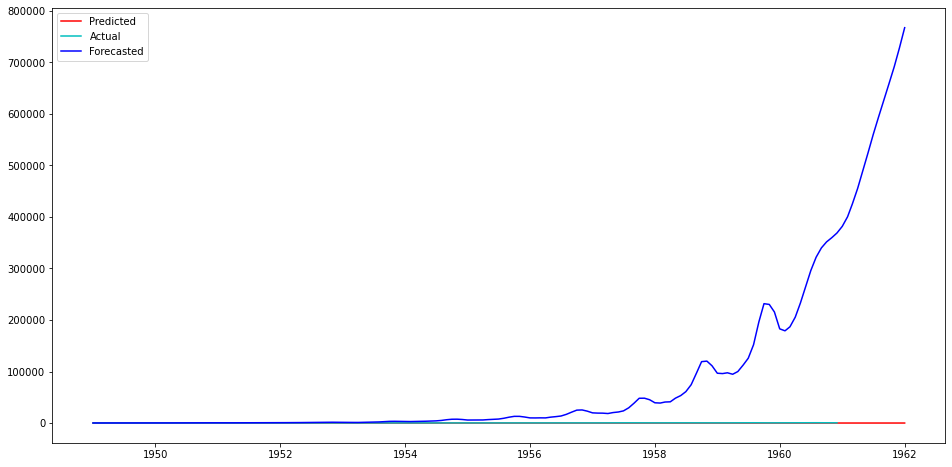

In [95]:
#Visualizing the forecasted values
plt.figure(figsize=(16,8))
plt.plot(forecasted_log, label = 'Predicted', color = 'r')   #use the forecasted values till 1960-12-01
plt.plot(df['# Passengers'], label = 'Actual', color = 'c')
plt.plot(forecasted_ARMA, color = 'b', label = 'Forecasted')   #use the forecasted values from 1961-01-01 to 1962-12-01
plt.legend()
plt.show()

**Observations:**

*********************End*********************